# Wasserstein distance in the latent space versus AD performance

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

path_vae_6410 = "SET THE PATH for the results on 30 seeds"
path_sparse = "SET THE PATH for the results on 30 seeds"


<Axes: xlabel='seed', ylabel='AveragePrecision'>

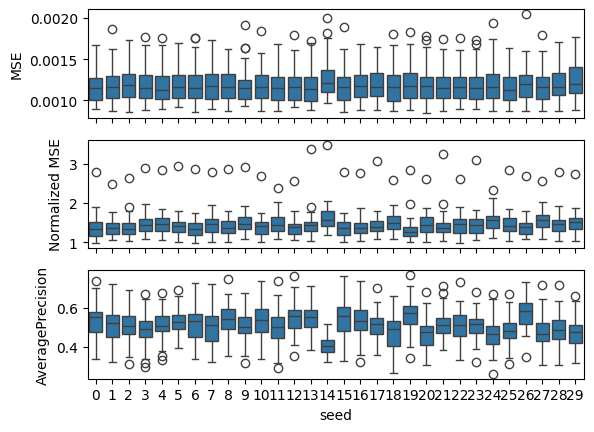

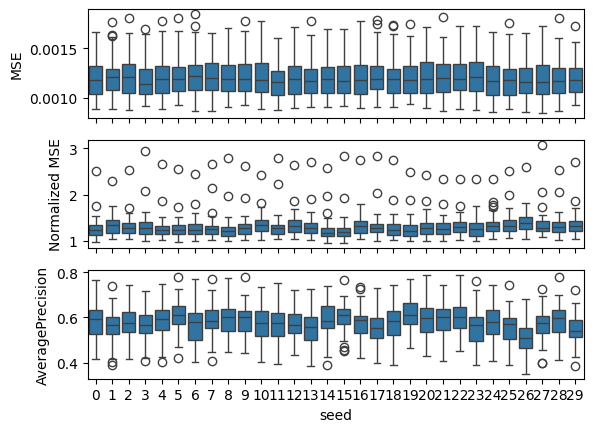

In [ ]:
def get_healthy_df_test_cn(path, n_seeds=30):
    dfs = []
    for seed in range(n_seeds):
        df = pd.read_csv(
            Path(path, f"seed_{seed}", "test_cn_baseline", "metrics_on_test.csv")
        )
        df["seed"] = seed
        dfs.append(df)
    return pd.concat(dfs)


def get_hypo_df(path, dataset="val_AD_30", n_seeds=30):
    dfs = []
    for seed in range(n_seeds):
        df = pd.read_csv(Path(path, f"seed_{seed}", dataset, "metrics_on_test.csv"))
        df["seed"] = seed
        dfs.append(df)
    return pd.concat(dfs)


def get_wasserstein_df(path, n_seeds=30):
    dfs = []
    for seed in range(n_seeds):
        df = pd.read_csv(Path(path, f"seed_{seed}", "wasserstein_dist.csv"))
        df["seed"] = seed
        dfs.append(df)
    return pd.concat(dfs)


hypo_dataset = "test_AD_30"

hdf_vae = get_healthy_df_test_cn(path_vae_6410)
hdf_sparse = get_healthy_df_test_cn(path_sparse)

hdf_vae = hdf_vae.rename(columns={"MSE_with_input": "MSE"})
hdf_sparse = hdf_sparse.rename(columns={"MSE_with_input": "MSE"})


df_vae = get_hypo_df(path_vae_6410, hypo_dataset)
df_sparse = get_hypo_df(path_sparse, hypo_dataset)

df_vae["Normalized MSE"] = df_vae["MSE_with_true_healthy"] / hdf_vae["MSE"]
df_sparse["Normalized MSE"] = df_sparse["MSE_with_true_healthy"] / hdf_sparse["MSE"]

w_vae = get_wasserstein_df(path_vae_6410)
w_sparse = get_wasserstein_df(path_sparse)

fig, ax = plt.subplots(3, 1, sharex=True)
sns.boxplot(hdf_vae, x="seed", y="MSE", ax=ax[0])
sns.boxplot(df_vae, x="seed", y="Normalized MSE", ax=ax[1])
sns.boxplot(df_vae, x="seed", y="AveragePrecision", ax=ax[2])

# plt.savefig('VAE_variability.png')

fig, ax = plt.subplots(3, 1, sharex=True)
sns.boxplot(hdf_sparse, x="seed", y="MSE", ax=ax[0])
sns.boxplot(df_sparse, x="seed", y="Normalized MSE", ax=ax[1])
sns.boxplot(df_sparse, x="seed", y="AveragePrecision", ax=ax[2])


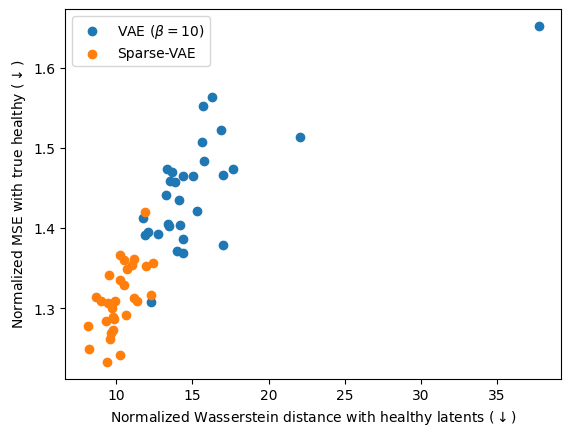

In [ ]:
def get_nmse(hdf, df):
    assert np.all(df["participant_id"] == hdf["participant_id"])
    assert np.all(df["session_id"] == hdf["session_id"])

    df["nMSE"] = df["MSE_with_true_healthy"] / hdf["MSE"]
    nmse = df.groupby(["seed"]).agg({"nMSE": "mean"})
    return np.array(nmse.nMSE)


def get_nwasserstein(w_df, dataset):
    return np.array(w_df[w_df["comparison"] == f"val_{dataset}"].value) / np.array(
        w_df[w_df["comparison"] == "val_train"].value
    )


nmse_vae = get_nmse(hdf_vae, df_vae)
nwas_vae = get_nwasserstein(w_vae, hypo_dataset)

nmse_sparse = get_nmse(hdf_sparse, df_sparse)
nwas_sparse = get_nwasserstein(w_sparse, hypo_dataset)

plt.scatter(nwas_vae, nmse_vae, label=r"VAE ($\beta=10$)")
plt.scatter(nwas_sparse, nmse_sparse, label="Sparse-VAE")
plt.ylabel(r"Normalized MSE with true healthy $(\downarrow)$")
plt.xlabel(r"Normalized Wasserstein distance with healthy latents $(\downarrow)$")
plt.legend()
# nmse_vae, nwas_vae

plt.savefig("Normalized_MSE_versus_wasserstein_test_1D_30.png")

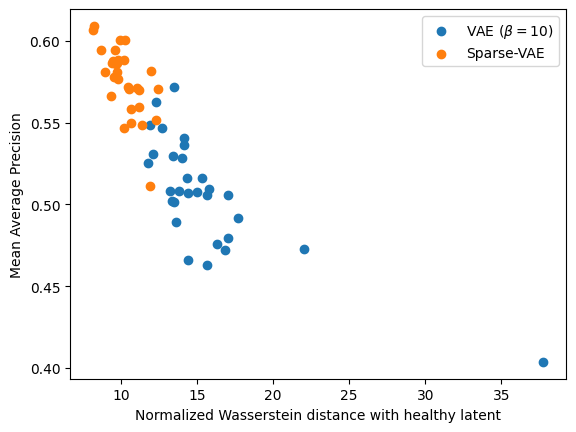

In [ ]:
def get_mean_aps(df_hy):
    return np.array(
        df_hy.groupby("seed").agg({"AveragePrecision": "mean"}).AveragePrecision
    )


ap_vae = get_mean_aps(df_vae)
ap_sparse = get_mean_aps(df_sparse)

plt.scatter(nwas_vae, ap_vae, label=r"VAE ($\beta=10$)")
plt.scatter(nwas_sparse, ap_sparse, label="Sparse-VAE")
plt.ylabel("Mean Average Precision")
plt.xlabel("Normalized Wasserstein distance with healthy latent")
plt.legend()

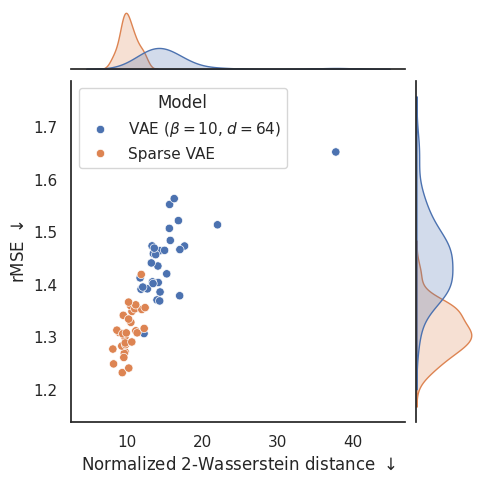

In [ ]:
ap_was_df = pd.DataFrame(
    data={
        "AveragePrecision": np.concat([ap_vae, ap_sparse]),
        "Wasserstein": np.concat([nwas_vae, nwas_sparse]),
        "NMSE": np.concat([nmse_vae, nmse_sparse]),
        "Model": [r"VAE ($\beta=10$, $d=64$)"] * len(ap_vae)
        + ["Sparse VAE"] * len(ap_sparse),
    }
)

# sns.jointplot(ap_was_df, x='Wasserstein', y='AveragePrecision', hue='Model')
# g = sns.JointGrid(data=ap_was_df,x='Wasserstein' ,y='AveragePrecision', hue='Model')
sns.set_theme(style="white", rc={"figure.figsize": (5, 1)})
g = sns.JointGrid(data=ap_was_df, x="Wasserstein", y="NMSE", hue="Model", height=5)

g.plot_joint(sns.scatterplot)
# g.plot_marginals(sns.histplot, bins=30, kde=True)
g.plot_marginals(sns.kdeplot, fill=True)
g.ax_joint.set_ylabel(r"rMSE $\downarrow$")
g.ax_joint.set_xlabel(r"Normalized 2-Wasserstein distance $\downarrow$")

plt.savefig("wasserstein_scatter_plot.pdf")

1.448008050452475 0.06861218647212755
1.3119226989433426 0.04192756103884622


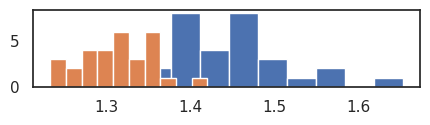

In [ ]:
plt.hist(nmse_vae)
print(nmse_vae.mean(), nmse_vae.std())
plt.hist(nmse_sparse)
print(nmse_sparse.mean(), nmse_sparse.std())

0.03349159362194294
0.020545362754680174


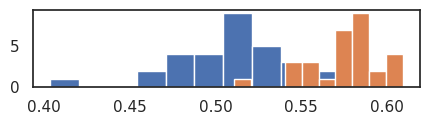

In [7]:
plt.hist(ap_vae)
print(ap_vae.std())
plt.hist(ap_sparse)
print(ap_sparse.std())